## Open AI mdoel

In [22]:
# %%capture
# pip install -r ../../requirements.txt

In [23]:
# pip install openai==0.28

In [24]:
import sys
import pandas as pd
import openai
import os
pd.set_option('display.max_colwidth', None) 


# set this on the path so that we can reference the commong data locations
sys.path.append("../scripts/")

from access_data import authenticate_google_drive, grab_google_drive_folder_data

drive = authenticate_google_drive()
df_labeled_full = grab_google_drive_folder_data(drive=drive, filename="combined_labeled_data.csv")
df_test_xgboost = grab_google_drive_folder_data(drive=drive, filename="xgboost_models_test.csv")

Successfully loaded 'combined_labeled_data.csv' into a DataFrame!
Successfully loaded 'xgboost_models_test.csv' into a DataFrame!


In [25]:
# df_labeled_full.head()

In [26]:
df_test_xgboost.head() 
test_df = pd.merge(df_labeled_full, df_test_xgboost, on=['submission_id', 'search_query'], how='inner')


In [27]:
test_df.columns 

Index(['submission_id', 'subreddit_topic', 'search_query', 'combine_text',
       'url', 'label', 'reviewer', 'label_encode',
       'multi_qa_mpnet_base_dot_v1_predicted_label',
       'BAAI_bge_small_en_v1.5_predicted_label',
       'all_MiniLM_L6_v2_predicted_label'],
      dtype='object')

In [28]:
import json

with open('credentials/openai_credentials.json') as f:
    config = json.load(f)

api_key = config["OPENAI_API_KEY"]

# Set your OpenAI API key
openai.api_key = api_key

In [29]:
import pandas as pd
import time

# Define the sentiment classification function using chat-based model
def classify_sentiment(post, brand):
    # prompt = f"Classify the sentiment of this reddit post. It's possible many of the posts are just seeking information about the brand. Label these information-seekers as 'neutral'. The other two possibilities are 'positive' or 'negative.' Only include the single word negative, neutral, or positive in your response: '{post}'"
    prompt = f"""Classify the sentiment of this Reddit post regarding the brand: {brand}.  
        - If the post is primarily seeking information about the brand without expressing a clear positive or negative opinion, label it as "Neutral."  
        - If the post expresses a favorable opinion about the brand, label it as "Positive."  
        - If the post expresses an unfavorable opinion about the brand, label it as "Negative."  

        Your response must be exactly one of the following words: "Negative", "Neutral", or "Positive" (without quotes and without any extra words or punctuation).  

        Reddit post: "{post}"
        """
    try:
        # Use the correct method for chat-based models
        response = openai.ChatCompletion.create(  
            model="gpt-3.5-turbo",  # Specify the chat model (like gpt-3.5-turbo). Can be expensive if you change it.
            messages=[
                {"role": "system", "content": "You are a helpful assistant."},
                {"role": "user", "content": prompt}
            ],
            max_tokens=10,  # Keep the output short (only the sentiment label)
            temperature=0.0  # Temperature set to 0 for deterministic output
        )
        time.sleep(0.025) 

        # Extract the sentiment from the response
        sentiment = response['choices'][0]['message']['content'].strip()
        return sentiment
    
    except Exception as e:
        print(f"Error classifying sentiment: {e}")
        return None  # Return None in case of error

################
# This costs $ - be careful!!
# Cost $0.64 to label all ~5000 reddit posts 

# Apply the function to the 'text' column to classify sentiment
test_df['open_ai_sentiment'] = test_df[['combine_text', 'search_query']].apply(lambda x: classify_sentiment(x['combine_text'], x['search_query']), axis=1)
################

In [30]:
# Store AI response as lower case
test_df['open_ai_sentiment'] = test_df['open_ai_sentiment'].str.title()

In [31]:
test_df['open_ai_sentiment'].value_counts() 

Neutral     22
Negative    10
Name: open_ai_sentiment, dtype: int64

## Evaluate dataset

In [32]:
open_ai_result = pd.DataFrame(test_df[['open_ai_sentiment', 'label']].value_counts()).reset_index().rename(columns={0: 'count', 'open_ai_sentiment': 'open_ai_prediction', 'label': 'actual'})
open_ai_result.head() 


,open_ai_prediction,actual,count
0,Neutral,Neutral,21
1,Negative,Negative,5
2,Negative,Neutral,5
3,Neutral,Positive,1



F1-score for each class:
Neutral: 0.8750
Negative: 0.6667
Positive: 0.0000

Macro F1-score: 0.5139

Classification Report:
              precision    recall  f1-score   support

     Neutral       0.95      0.81      0.88        26
    Negative       0.50      1.00      0.67         5
    Positive       0.00      0.00      0.00         1

    accuracy                           0.81        32
   macro avg       0.48      0.60      0.51        32
weighted avg       0.85      0.81      0.82        32



/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


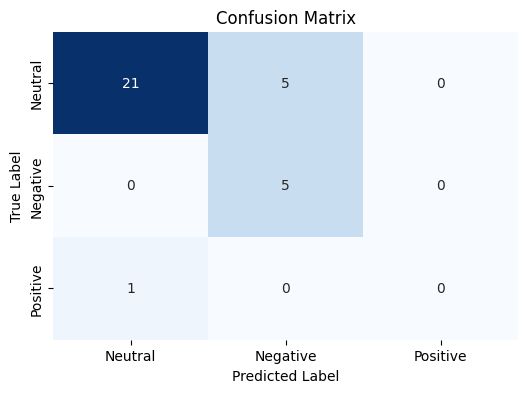

In [33]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, classification_report

# Extract unique classes dynamically
y_true = test_df['label']
y_pred = test_df['open_ai_sentiment']
predicted_classes = test_df['label'].unique()

# Calculate per-class F1 scores (without specifying labels explicitly)
f1 = f1_score(y_true, y_pred, average=None, labels=predicted_classes)  # Per-class F1
macro_f1 = f1_score(y_true, y_pred, average="macro")  # Macro F1 (since it's common for imbalanced datasets)

# Print results
print("\nF1-score for each class:")
for i, class_label in enumerate(predicted_classes):
    print(f"{class_label}: {f1[i]:.4f}")

print(f"\nMacro F1-score: {macro_f1:.4f}")

# Print full classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, labels=predicted_classes))

y_pred = test_df['open_ai_sentiment']
y_true = test_df['label']

cm = confusion_matrix(y_true, y_pred, labels=["Neutral", "Negative", "Positive"])

# Convert confusion matrix to a DataFrame for better readability
cm_df = pd.DataFrame(cm, index=["Neutral", "Negative", "Positive"], columns=["Neutral", "Negative", "Positive"])

# Print confusion matrix
# print("Confusion Matrix:")
# print(cm_df)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm_df, annot=True, fmt="g", cmap="Blues", cbar=False)

# # Labels and title
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")

# Show the plot
plt.show()

## Evaluate XGBoost and Open AI approach 


In [34]:
pred_columns = [ 
       'multi_qa_mpnet_base_dot_v1_predicted_label',
       'BAAI_bge_small_en_v1.5_predicted_label',
       'all_MiniLM_L6_v2_predicted_label', 'open_ai_sentiment']

In [35]:
test_df[pred_columns].head() 


,multi_qa_mpnet_base_dot_v1_predicted_label,BAAI_bge_small_en_v1.5_predicted_label,all_MiniLM_L6_v2_predicted_label,open_ai_sentiment
0,Neutral,Neutral,Neutral,Negative
1,Neutral,Neutral,Neutral,Neutral
2,Neutral,Neutral,Neutral,Negative
3,Neutral,Neutral,Neutral,Neutral
4,Neutral,Neutral,Neutral,Neutral


In [36]:
result_dict = {"Model": [], "F1 Macro Score": []}

for pred_col in pred_columns:
    f1 = f1_score(test_df["label_encode"], test_df[pred_col], average="macro")
    col_name = pred_col.replace("_predicted_label", "")  # Remove suffix for cleaner name
    
    # Append results
    result_dict["Model"].append(col_name)
    result_dict["F1 Macro Score"].append(f1)

# Convert to DataFrame
f1_results_df = pd.DataFrame(result_dict)


In [37]:
print(f1_results_df.sort_values(by='F1 Macro Score', ascending=False).reset_index(drop=True).to_markdown())

|    | Model                      |   F1 Macro Score |
|---:|:---------------------------|-----------------:|
|  0 | open_ai_sentiment          |         0.513889 |
|  1 | multi_qa_mpnet_base_dot_v1 |         0.386364 |
|  2 | BAAI_bge_small_en_v1.5     |         0.374242 |
|  3 | all_MiniLM_L6_v2           |         0.298851 |


# Based on results, score all leads with the Open AI 

In [38]:
df_filtered = grab_google_drive_folder_data(drive=drive, filename="reddit_filtered_data.csv")

Successfully loaded 'reddit_filtered_data.csv' into a DataFrame!


In [39]:
df_filtered['open_ai_sentiment'] = df_filtered[['combine_text', 'search_query']].apply(lambda x: classify_sentiment(x['combine_text'], x['search_query']), axis=1)


In [40]:
df_filtered['open_ai_sentiment'].value_counts() 

Neutral     2353
Negative    1516
Positive     292
Name: open_ai_sentiment, dtype: int64

In [41]:
from access_data import authenticate_google_drive, save_google_drive_data

drive = authenticate_google_drive()
save_google_drive_data(drive=drive, 
                       dataframe=df_filtered, 
                       filename="analyze_data.csv")

File 'analyze_data.csv' uploaded successfully to folder 1Ktcv4eaR7kH0teyGuLph4LSYWxI1qkIS!
